# ML TDOA-Based Source Localization

In [35]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import math, random
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper functions

In [23]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    from : https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

def sphere_micsArray(n_mics, room_dim, radius=0.01, randomize=False):
    rnd = 1.
    if randomize:
        rnd = random.random() * n_mics

    points = []
    offset = 2./n_mics
    increment = math.pi * (3. - math.sqrt(5.))

    for i in range(n_mics):
        y = ((i * offset) - 1) + (offset / 2) 
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % n_mics) * increment

        x = math.cos(phi) * r 
        z = math.sin(phi) * r 
        
        norm = np.sqrt(x**2 + y**2 + z**2)
        x /= (1/radius)*norm
        y /= (1/radius)*norm
        z /= (1/radius)*norm
        points.append([x+ room_dim[0]/2, y + room_dim[1]/2 , z + room_dim[2]/2])

    return np.array(points)

#### 1. Create Room Setup

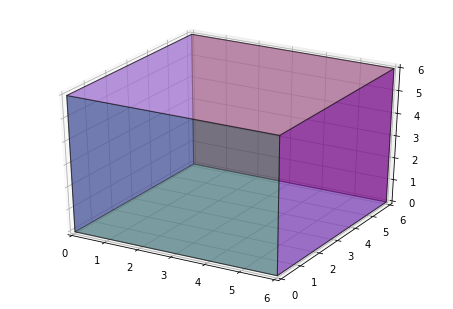

In [24]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 6, 6, 6
room_dim = np.array([room_dimX, room_dimY, room_dimZ])

#Sampling frequency
fs = 16000 # 16kHz

room = pra.ShoeBox(room_dim, fs=fs, max_order = 4, absorption=0.2)

# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

Create and visualize microphone array

In [25]:
n_mics = 50
radius = 0.01 #radius of the sphere in meters
mics_pos = sphere_micsArray(n_mics, room_dim, radius=0.01)

# the fs of the microphones is the same as the room
mic_array = pra.MicrophoneArray(mics_pos.T, room.fs)
room.add_microphone_array(mic_array)

In [26]:
mics_pos.shape

(50, 3)

Visualize mic array

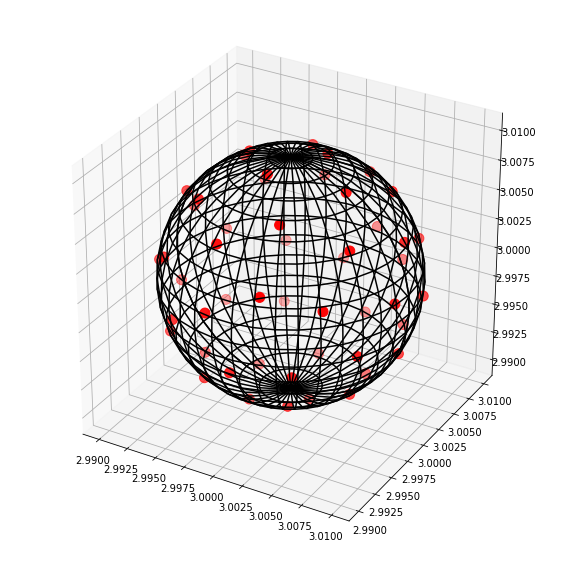

In [27]:
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)

x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

norm = np.sqrt(x**2 + y**2 + z**2)
x /= 100*norm
y /= 100*norm
z /= 100*norm

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
fig.set_size_inches(10,10,10)
ax.plot_wireframe(x + room_dim[0]/2, y + room_dim[1]/2, z + room_dim[2]/2, color='k', rstride=1, cstride=1)
ax.scatter(mics_pos[:,0], mics_pos[:,1], mics_pos[:,2], s=100, c='r', zorder=10)

Add source and simulate sound propagation

In [28]:
# Add source of 5 seconds duration 
rng = np.random.RandomState(23) 
duration_samples = 5*int(fs) 
# White noise
source_signal = rng.randn(duration_samples)

source_X, source_Y, source_Z  = 2, 2, 2

source_location = [source_X, source_Y, source_Z]

room.add_source(source_location, signal=source_signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir
room.simulate()

### 2. Computation of the true TDOAs

In [49]:
def compute_tdoa(source_pos, mic1_pos, mic2_pos, c=343.0):
    
    src_to_mic1 = np.linalg.norm(source_pos - mic1_pos)
    src_to_mic2 = np.linalg.norm(source_pos - mic2_pos)
    
    return (src_to_mic1 - src_to_mic2)/c

def compute_M_tdoa(source_pos, mics_pos, indexes_1, indexes_2, M=50):
    '''
    This function computes the M TDOAs between randomly selected mics
    '''
    _, dim = mics_pos.shape
    
    assert dim==3, 'mic_array shape must be of the form (number_mics, dimension)'
    #assert n_mics>=M, 'max number of TDOA pair must be less than {n}'.format(n=n_mics)
    
    tdoas = []
    
    for i in range(M):
        tdoa = compute_tdoa(source_pos, mics_pos[indexes_1[i], :], mics_pos[indexes_2[i], :])
        tdoas.append(tdoa)
        
    return np.array(tdoas)

In [44]:
def compute_tdoa_estimates(source_location, mic_array, indexes_1, indexes_2, fs, max_tau, M=50):
    '''
    This function computes the ground truth TDOAs and their respictive estimate using 
    the GCC-PHAT method
    '''
    
    tdoa_estimates = []
    for i in tqdm(range(M)):
        tdoa_estimate, _ = gcc_phat(mic_array[indexes_1[i],:], mic_array[indexes_2[i],:], max_tau=max_tau, fs=fs)
        tdoa_estimates.append(tdoa_estimate)
    return np.array(tdoa_estimates)

In [50]:
def compute_trueTDOA_estimateTDOA(source_pos, mics_pos, mics_signals, fs, max_tau, M=50):
    
    n_mics, _ = mics_pos.shape

    indexes_1 = np.random.randint(0, n_mics, size=M)
    indexes_2 = np.random.randint(0, n_mics, size=M)
    
    tdoa_gt = compute_M_tdoa(source_pos, mics_pos, indexes_1, indexes_2, M)
    tdoa_estimates = compute_tdoa_estimates(source_pos, mics_signals, indexes_1, indexes_2, fs, max_tau, M)
    
    return tdoa_gt, tdoa_estimates

In [52]:
tdoa_gt, tdoa_estimates = compute_trueTDOA_estimateTDOA(source_location, mics_pos, room.mic_array.signals, fs, 2*radius/343.0)

100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


<Container object of 3 artists>

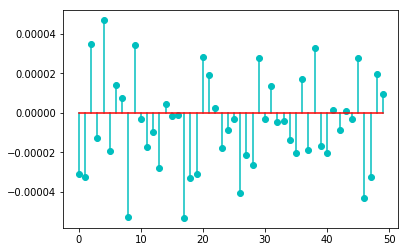

In [74]:
plt.stem(tdoa_gt, linefmt='c-', markerfmt='co', basefmt='r-')

<Container object of 3 artists>

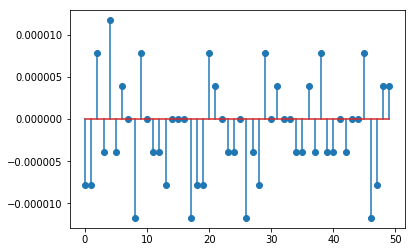

In [54]:
plt.stem(tdoa_estimates)

#### 3. Perform minimization

In [75]:
from scipy.optimize import minimize